In [ ]:
%pip install torch
%pip install matplotlib
%pip install scikit-learn
%pip install tqdm
%pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from torch.nn import Module, Linear, ReLU
from torch.nn.functional import softmax
from torch import matmul, zeros, concat, cat
from math import sqrt

class TransformerLayer(Module):
    def __init__(self, d_model, d_internal, d_ff, n_heads, max_seq_len=20):
        super().__init__()
        self.d_model = d_model
        self.d_internal = d_internal
        self.n_heads = n_heads
        self.max_seq_len = max_seq_len
        self.last_map = zeros(n_heads, max_seq_len, max_seq_len)

        # 1.1) Define QKV linear transformations
        self.q_proj = Linear(d_model, d_internal * n_heads)
        self.k_proj = Linear(d_model, d_internal * n_heads)
        self.v_proj = Linear(d_model, d_internal * n_heads)

        # 1.2) Define multi-head attention output projection
        self.mha_proj = Linear(d_internal * n_heads, d_model)

        # 1.3) Define feedforward layers
        self.ff1 = Linear(d_model, d_ff)
        self.activation = ReLU()
        self.ff2 = Linear(d_ff, d_model)

    def forward(self, input_vecs):
        seq_len, _ = input_vecs.shape
        residual = input_vecs.clone()

        # 1.5) Calculate MHA up to the attention map
        q = self.q_proj(input_vecs).view(seq_len, self.n_heads, self.d_internal)
        k = self.k_proj(input_vecs).view(seq_len, self.n_heads, self.d_internal)
        v = self.v_proj(input_vecs).view(seq_len, self.n_heads, self.d_internal)

        # Transpose for attention: [n_heads, seq_len, d_internal]
        q = q.transpose(0, 1)
        k = k.transpose(0, 1)
        v = v.transpose(0, 1)

        # Scaled dot-product attention
        scores = matmul(q, k.transpose(-2, -1)) / sqrt(self.d_internal)
        attn_map = softmax(scores, dim=-1)

        # 1.6) Cache latest attention map
        self.last_map[:, :seq_len, :seq_len] = attn_map.detach()

        # 1.7) Complete MHA
        attn_output = matmul(attn_map, v)
        attn_output = attn_output.transpose(0, 1).contiguous().view(seq_len, self.n_heads * self.d_internal)
        mha_output = self.mha_proj(attn_output)

        # 1.8) Add residual
        x = mha_output + residual

        # 1.9) Apply feedforward and add second residual
        ff_output = self.ff1(x)
        ff_output = self.activation(ff_output)
        ff_output = self.ff2(ff_output)
        x = x + ff_output

        return x

In [ ]:
import random
from torch import manual_seed, randn
from numpy import round as npround

random.seed(42)
manual_seed(42)

# Single-head test case
input_tensor = randn(5, 8)
sh_attn = TransformerLayer(d_model=8, d_internal=32, d_ff=64, n_heads=1, max_seq_len=5)
single_head_output = npround(sh_attn(input_tensor).detach().numpy(), 4)
single_head_map = npround(sh_attn.last_map.detach().numpy(), 4)

print('Single-head output')
print(single_head_output, '\n')
print('Single-head attention map')
print(single_head_map, '\n')

print('='*60, '\n')

# Multi-head test case
mh_attn = TransformerLayer(d_model=8, d_internal=16, d_ff=128, n_heads=2, max_seq_len=5)
multi_head_output = npround(mh_attn(input_tensor).detach().numpy(), 4)
multi_head_maps = npround(mh_attn.last_map.detach().numpy(), 4)

print('Multi-head output')
print(multi_head_output, '\n')
print('Multi-head attention maps')
print(multi_head_maps)

Single-head output
[[ 2.2838  1.5244  0.8004 -2.9931  0.589  -0.8144 -0.1878 -2.4291]
 [-1.1199  1.5985 -0.2764 -1.6976 -0.5537 -0.2992 -1.1663 -0.1034]
 [ 1.6057 -0.0639 -0.236   0.0499 -0.5856  1.5798  0.844   0.9629]
 [ 0.3906  0.0176  1.5224 -1.2355  1.6741  1.1942 -1.2787 -0.9399]
 [-1.5059  1.3385 -0.244   1.3421  1.5637  0.644  -1.9173 -1.3539]] 

Single-head attention map
[[[0.1903 0.3172 0.1341 0.1319 0.2265]
  [0.2291 0.2353 0.2829 0.1432 0.1095]
  [0.2137 0.1621 0.1954 0.1957 0.2331]
  [0.1552 0.1517 0.1744 0.2308 0.288 ]
  [0.1125 0.1147 0.1225 0.1859 0.4644]]] 


Multi-head output
[[ 1.5158  1.0291  0.5479 -1.8851  0.5383 -1.0615 -0.0882 -1.7973]
 [-0.6814  1.7653 -0.6277 -1.1421 -0.2932 -0.0086 -0.9963  0.5146]
 [ 1.4643 -0.4265 -0.5724  0.9202 -0.3251  1.3543  1.1753  1.6216]
 [-0.0789  0.3658  1.0965 -0.6266  1.7939  1.0766 -1.3486 -0.6459]
 [-1.8123  0.8444 -0.5449  2.7515  2.1552 -0.337  -1.1889 -1.4461]] 

Multi-head attention maps
[[[0.0688 0.2591 0.1634 0.1492 0.35

In [ ]:
import torch
from torch import tensor, LongTensor, FloatTensor, log
from torch.nn import Sequential, Embedding, Linear, Module
from torch.nn.functional import log_softmax

class Transformer(Module):
    def __init__(self, vocab_size, max_seq_len, d_model, d_internal, num_classes, d_ff, num_layers, num_heads):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.d_model = d_model
        layers = [TransformerLayer(d_model, d_internal, d_ff, num_heads, max_seq_len) for _ in range(num_layers)]
        self.encoders = Sequential(*layers)
        self.decoder = Linear(d_model, num_classes)
        self.word_embedding = Embedding(vocab_size, d_model)
        self.positional_embedding = Embedding(max_seq_len, d_model)

    def forward(self, indices):
        # Pad indices to max_seq_len
        seq_len = indices.shape[0]
        if seq_len < self.max_seq_len:
            padding = torch.zeros(self.max_seq_len - seq_len, dtype=torch.long, device=indices.device)
            indices = torch.cat([indices, padding])

        # Generate positional indices for the full padded length
        positions = torch.arange(self.max_seq_len, device=indices.device)
        x = self.word_embedding(indices) + self.positional_embedding(positions)

        # Layer forward passes
        x = self.encoders(x)
        logits = self.decoder(x)
        log_probs = log_softmax(logits, dim=-1)
        maps = torch.stack([layer.last_map for layer in self.encoders])

        return log_probs, maps

In [ ]:
transformer = Transformer(vocab_size=100, max_seq_len=5, d_model=16, d_internal=32, num_classes=3, d_ff=64, num_layers=2, num_heads=4)
indices = LongTensor([1, 1, 2, 2, 3])
embeddings = transformer.word_embedding(indices) + transformer.positional_embedding(torch.arange(5))
print(embeddings)


tensor([[ 1.0863, -0.3956,  1.1026, -0.1683, -1.0393, -2.5539, -1.3918,  0.7796,
          0.2833, -0.3516,  1.2111,  0.3293,  0.3008,  1.5349, -0.4073,  0.3035],
        [-0.4854, -0.4227,  0.5792, -0.2024, -1.1750, -0.4160, -0.7286,  1.3948,
         -0.0799, -0.4244, -0.5290, -0.0352, -0.9142,  1.0897, -0.8322,  1.0263],
        [ 1.4620, -1.4525, -0.6506, -0.5818,  1.5853, -0.4767,  1.9863, -0.6256,
         -0.4486,  0.2694, -1.6227, -0.0962, -1.4276,  0.5084, -0.3002,  0.1471],
        [ 1.6329, -1.4937, -1.2408, -0.0210,  0.0438,  0.2787,  0.8699, -1.6276,
          0.7282,  0.8110, -2.1726, -0.7692,  0.0909, -0.7967, -1.8262,  0.5957],
        [-2.4370,  0.2850,  0.5202, -0.8246,  3.0568, -0.7814,  0.5630,  1.4699,
         -0.8431, -1.4375,  0.1439, -0.3277, -1.9051, -0.5489, -0.5178,  0.7037]],
       grad_fn=<AddBackward0>)


In [ ]:
import numpy as np
from torch import LongTensor, cat

def pad_tensor(tensor, max_len=20, pad_value=-1):
    """Padding a tensor to max_len with pad_value."""
    current_len = tensor.shape[0]
    if current_len < max_len:
        padding = LongTensor([pad_value] * (max_len - current_len))
        return cat([tensor, padding])
    return tensor[:max_len]  # Truncating if longer than max_len

def task1(input: str) -> LongTensor:
    output = np.zeros(len(input))
    for i in range(len(input)):
        output[i] = min(2, len([c for c in input[:i] if c == input[i]]))
    return pad_tensor(LongTensor(output))  # Pad to 20

def task2(input: str) -> LongTensor:
    output = np.zeros(len(input))
    for i in range(len(input)):
        output[i] = min(2, len([c for c in input if c == input[i]]) - 1)
    return pad_tensor(LongTensor(output))  # Pad to 20

def indexer(input: str) -> LongTensor:
    char_to_idx = {c: i for i, c in enumerate(' abcdefghijklmnopqrstuvwxyz')}
    return LongTensor([char_to_idx[c] for c in input])

train_strings, train_ids, train_task1, train_task2 = [], [], [], []
eval_strings, eval_ids, eval_task1, eval_task2 = [], [], [], []

with open('lettercounting-train.txt', 'r', encoding='utf8') as train_file:
    for line in train_file:
        s = line.strip()
        train_strings.append(s)
        train_ids.append(indexer(s))
        train_task1.append(task1(s))
        train_task2.append(task2(s))

with open('lettercounting-dev.txt', 'r', encoding='utf8') as eval_file:
    for line in eval_file:
        s = line.strip()
        eval_strings.append(s)
        eval_ids.append(indexer(s))
        eval_task1.append(task1(s))
        eval_task2.append(task2(s))

In [ ]:
s = "ed by rank and file"
ids = indexer(s)
t1 = task1(s)
t2 = task2(s)
print(f"String: {s}")
print(f"ID Tensor: {ids}")
print(f"Task 1 Tensor: {t1}")
print(f"Task 2 Tensor: {t2}")

String: ed by rank and file
ID Tensor: tensor([ 5,  4,  0,  2, 25,  0, 18,  1, 14, 11,  0,  1, 14,  4,  0,  6,  9, 12,
         5])
Task 1 Tensor: tensor([ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  2,  1,  1,  1,  2,  0,  0,  0,
         1, -1])
Task 2 Tensor: tensor([ 1,  1,  2,  0,  0,  2,  0,  1,  1,  0,  2,  1,  1,  1,  2,  0,  0,  0,
         1, -1])


Epoch 10 - Task 1: 100%|██████████| 10000/10000 [00:44<00:00, 222.58it/s]


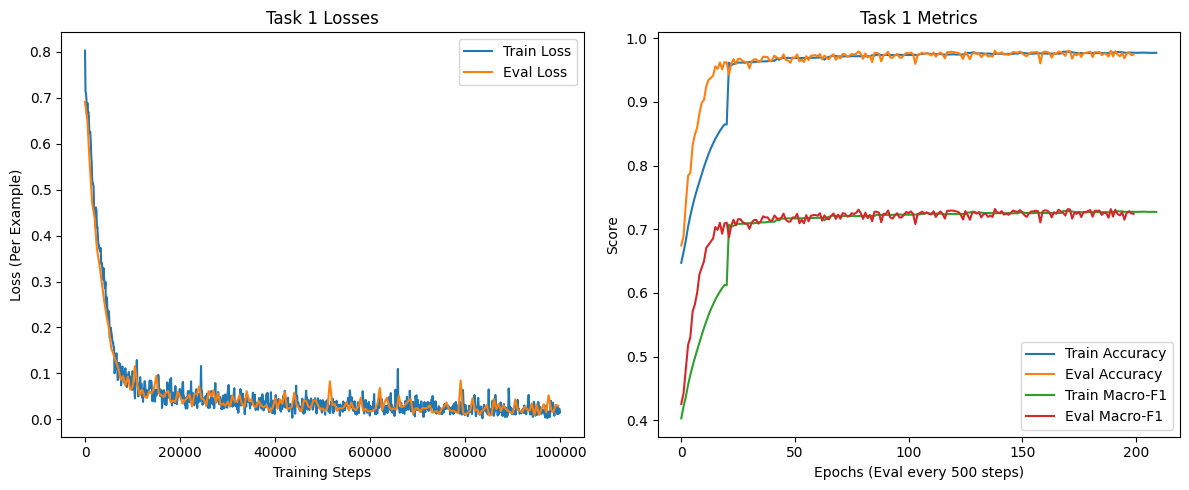

Task 1 Final Eval Accuracy: 0.9740
Task 1 Final Eval Macro-F1: 0.7242


Epoch 10 - Task 2: 100%|██████████| 10000/10000 [00:44<00:00, 222.58it/s]


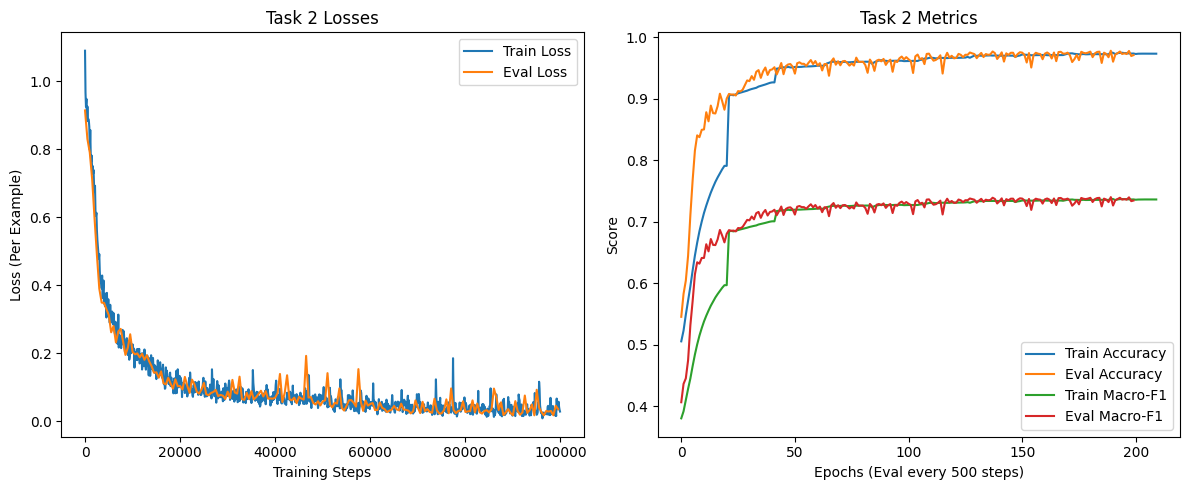

Task 2 Final Eval Accuracy: 0.9706
Task 2 Final Eval Macro-F1: 0.7344


In [ ]:
import matplotlib.pyplot as plt
from torch.nn import NLLLoss
from torch.optim import Adam
from torch import no_grad
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

def plot_maps(maps, text):
    maps = maps.detach().numpy()
    num_layers, num_heads = maps.shape[0], maps.shape[1]
    fig, axs = plt.subplots(num_heads, num_layers, figsize=(num_layers*4, num_heads*4))
    for h in range(num_heads):
        for l in range(num_layers):
            ax = axs[h, l] if num_heads > 1 and num_layers > 1 else axs[l] if num_heads == 1 else axs[h]
            ax.imshow(maps[l, h], cmap='hot', interpolation='nearest')
            ax.set_xticks(np.arange(len(text)), labels=text)
            ax.set_yticks(np.arange(len(text)), labels=text)
            ax.xaxis.tick_top()
    plt.show()

# Training function
def train_model(task_data, task_name, train_ids, eval_ids, eval_data, num_epochs=10):
    model = Transformer(vocab_size=27, max_seq_len=20, d_model=64, d_internal=32, num_classes=3, d_ff=128, num_layers=1, num_heads=1)
    optimizer = Adam(model.parameters(), lr=0.001)
    criterion = NLLLoss(ignore_index=-1)  # Ignoring padded positions

    train_losses = []
    eval_losses = []
    train_accs, train_f1s = [], []
    eval_accs, eval_f1s = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_preds, epoch_train_golds = [], []
        running_loss = 0.0

        for i in tqdm(range(len(train_ids)), desc=f"Epoch {epoch+1} - {task_name}"):
            optimizer.zero_grad()
            log_probs, _ = model(train_ids[i])
            loss = criterion(log_probs, task_data[i])  # Target is now (20,)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = log_probs.argmax(dim=-1)
            epoch_train_preds.extend(preds.tolist())
            epoch_train_golds.extend(task_data[i].tolist())

            if (i + 1) % 100 == 0:
                train_losses.append(running_loss / 100)
                running_loss = 0.0

            if (i + 1) % 500 == 0:
                model.eval()
                with torch.no_grad():
                    eval_loss = 0.0
                    eval_preds, eval_golds = [], []
                    for j in range(len(eval_ids)):
                        log_probs, _ = model(eval_ids[j])
                        eval_loss += criterion(log_probs, eval_data[j]).item()
                        preds = log_probs.argmax(dim=-1)
                        eval_preds.extend(preds.tolist())
                        eval_golds.extend(eval_data[j].tolist())

                    eval_losses.append(eval_loss / len(eval_ids))
                    train_acc = accuracy_score(epoch_train_golds, epoch_train_preds)
                    train_f1 = f1_score(epoch_train_golds, epoch_train_preds, average='macro')
                    eval_acc = accuracy_score(eval_golds, eval_preds)
                    eval_f1 = f1_score(eval_golds, eval_preds, average='macro')
                    train_accs.append(train_acc)
                    train_f1s.append(train_f1)
                    eval_accs.append(eval_acc)
                    eval_f1s.append(eval_f1)
                model.train()

        train_accs.append(accuracy_score(epoch_train_golds, epoch_train_preds))
        train_f1s.append(f1_score(epoch_train_golds, epoch_train_preds, average='macro'))

    # Plotting (unchanged from previous)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(train_losses)) * 100, train_losses, label='Train Loss')
    plt.plot(np.arange(len(eval_losses)) * 500, eval_losses, label='Eval Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss (Per Example)')
    plt.title(f'{task_name} Losses')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(eval_accs, label='Eval Accuracy')
    plt.plot(train_f1s, label='Train Macro-F1')
    plt.plot(eval_f1s, label='Eval Macro-F1')
    plt.xlabel('Epochs (Eval every 500 steps)')
    plt.ylabel('Score')
    plt.title(f'{task_name} Metrics')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"{task_name} Final Eval Accuracy: {eval_accs[-1]:.4f}")
    print(f"{task_name} Final Eval Macro-F1: {eval_f1s[-1]:.4f}")
    return model

# Run training
model_task1 = train_model(train_task1, "Task 1", train_ids, eval_ids, eval_task1)
model_task2 = train_model(train_task2, "Task 2", train_ids, eval_ids, eval_task2)

5.1: Analysis of Provided Models
Hypothesis:

Task 1 (Before): Attention focuses on preceding tokens. For "e", it attends to prior "e"s; for "a", "n", "d", " ", it looks at earlier occurrences, showing a leftward bias.
Task 2 (Before/After): Attention spreads across the sequence, capturing both prior and subsequent occurrences, resulting in a more distributed pattern.
Similarities: Both prioritize relevant tokens for counting.
Differences: Task 1’s maps are asymmetric (past-focused), while Task 2’s are symmetric due to bidirectional counting.

As I used padding, I did not face any issues that needed to be addressed on learning rate, loss function, etc. I used the template which was given.

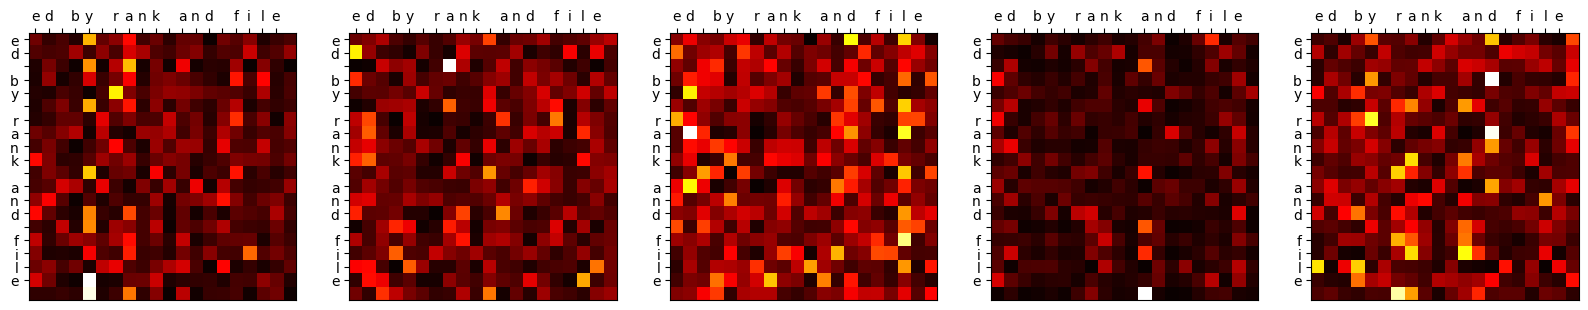

In [ ]:
model_multi_layer = Transformer(27, 20, 64, 32, 3, 128, 5, 1)
# Reusing training loop with num_layers=5
log_probs, maps = model_multi_layer(indexer("ed by rank and file"))
plot_maps(maps, "ed by rank and file")

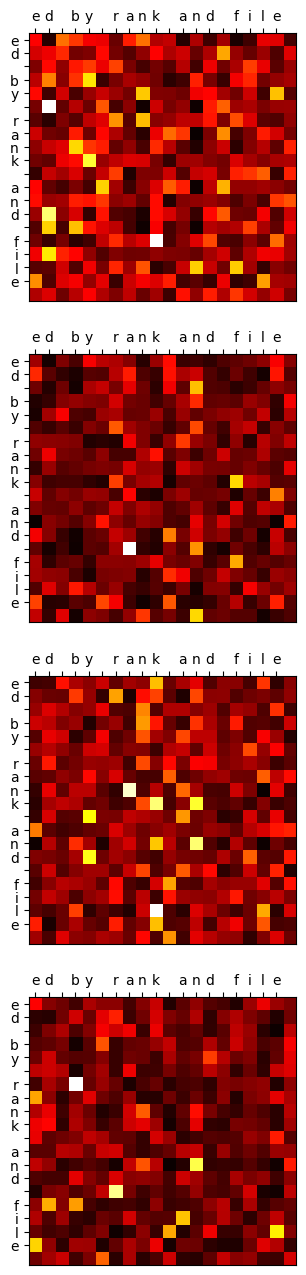

In [ ]:
model_multi_head = Transformer(27, 20, 64, 32, 3, 128, 1, 4)
# Reusing training loop with num_heads=4
log_probs, maps = model_multi_head(indexer("ed by rank and file"))
plot_maps(maps, "ed by rank and file")

Hypothesis: Each head specializes in different aspects (e.g., local vs. global counts, specific characters), enhancing robustness in bidirectional counting.
